

# Proyecto

### Equipo:

- Juan Carlos Araya
- Javiera Palominos

- Usuario codalab: Kuanki1

### Link de repositorio de GitHub: `https://github.com/kuanki1/MDS7202Labs/blob/main/Proyecto/proyecto.ipynb`




## 1. Introducción

El objetivo de este proyecto consiste en poder predecir la recepción del público y las ventas que tendrá un juego publicado en Steam. Por lo que se utilizarán dos modelos: uno de clasificación, para predecir que tipo de valoraciones tendrá el juego; y otro modelo de regresión, que se utilizará para predecir las ventas del juego.

Los datos que se dispone es un dataset de entrenamiento con 7881 filas y 16 características, las cuales muestran el nombre del juego, la fecha en la cual fue lanzado, sus desarrolladores, sus distribuidores, la recepción que tuvo, las ventas, entre otras cosas (estas se profundizarán en el EDA).

Las variables objetivo son:
- rating, que clasifica las valoraciones del juego en 5 grupos: [Negative, Mixed, Mostly Positive, Positive, Very Positive], siendo esta una variable categórica.
- estimated_sells, que representa las ventas del juego, esta variable es un númerica.

Para las valoraciones se usará la métrica f1_weighted y para las ventas se usará la métrica r2.

El baseline se realizó con modelos Dummy: DummyClassifier y DummyRegressor. Para los modelos finales se evalúo 2 opciones para cada una de las soluciones. En el caso de la clasificación se eligió por un lado RandomForestClassifer, debido a que su arquitectura se comporta bien con múltiples variables, por otro lado también se hicieron pruebas con KNN, ya que este clasificador tiene buen desempeño en problemas de clasificación múltiple (en este caso 5 clústers). Para la regresión se probó por un lado RandomForestRegressor por la característica mencionada anteriormente y ElasticNet por su buen desempeño en problemas de regresión con datos relativamente reducidos (dataset con menos de 100.000 filas).

---
## 2. Análisis Exploratorio de Datos

En esta sección se cargan y preparan los datos para así dar inicio al proyecto, se importan también las librerias necesarias.
Se definen los tipos de algunas variables, para que luego al aplicar la función profile_serie, esta se muestre de la forma adecuada.
Se muestra también un resumen de lo que es el data set, como su cantidad de filas y columnas, los nombres de estas últimas, valores nulos y duplicados, etc.

In [1]:
# Libreria Core
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Libreria EDA
from scipy import stats
from pandas.api.types import is_numeric_dtype
from pandas.core.dtypes.common import is_datetime_or_timedelta_dtype
from IPython.display import display, Markdown, Latex

# Libreria para implementar Bag of Words
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize  
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

# Libreria Preprocessing - Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Libreria entrenamiento
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression
from sklearn.model_selection import train_test_split

# Libreria Clasififcadores
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Libreria Regresores
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

# Libreria métricas de evaluación
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

# Libreria Halving Grid Search
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kuanki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kuanki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_train = pd.read_pickle("train.pickle")
df_train = df_train.astype(
    {
        "english": bool,
        "required_age": object,
        "short_description": str,
    }
)
display(df_train.head())

dims = df_train.shape

print("El DataFrame tiene", dims[0], "filas y", dims[1] ,"columnas")
print("Columnas Dataset: ", list(df_train.columns), "\n")
print("Tipos de Variables: ", "\n", df_train.dtypes, "\n")
print("Cantidad de valores nulos por columna:")
print(df_train.isna().sum())
print("Presenta un total de", len(df_train[df_train.duplicated(subset=["name"])]) ,"filas con nombres duplicados.")
print("Descripción numérica del Dataframe:")
display(df_train.describe(include=[np.number]))

,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,tags,achievements,average_playtime,price,short_description,estimated_sells,rating
0,An Aspie Life,2018-03-29,True,Bradley Hennessey;Joe Watson,EnderLost Studios,windows,0,Single-player;Steam Achievements,Adventure;Casual;Free to Play;Indie;Simulation,Free to Play;Adventure;Indie,23,0,0.00,One day your roommate Leaves for no reason. Yo...,3914,Mixed
1,GhostControl Inc.,2014-06-06,True,bumblebee,Application Systems Heidelberg,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Casual;Indie;Simulation;Strategy,Turn-Based;Indie;Simulation,53,65,10.99,Manage a team of ghosthunters and free London ...,10728,Mixed
2,Deponia,2012-08-06,True,Daedalic Entertainment,Daedalic Entertainment,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie,Adventure;Point & Click;Comedy,19,217,6.99,"In Deponia, the world has degenerated into a v...",635792,Positive
3,Atlas Reactor,2016-10-04,True,Trion Worlds,Trion Worlds,windows,0,Multi-player;Online Multi-Player;Steam Achieve...,Free to Play;Strategy,Free to Play;Multiplayer;Strategy,121,1240,0.00,SEASON 6 NOW LIVE! The battle for Atlas contin...,253864,Positive
4,CHUCHEL,2018-03-07,True,Amanita Design,Amanita Design,windows;mac,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Casual;Indie,Adventure;Indie;Casual,7,245,7.99,CHUCHEL is a comedy adventure game from the cr...,49818,Mostly Positive


El DataFrame tiene 7881 filas y 16 columnas
Columnas Dataset:  ['name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'tags', 'achievements', 'average_playtime', 'price', 'short_description', 'estimated_sells', 'rating'] 

Tipos de Variables:  
 name                   object
release_date           object
english                  bool
developer              object
publisher              object
platforms              object
required_age           object
categories             object
genres                 object
tags                   object
achievements            int64
average_playtime        int64
price                 float64
short_description      object
estimated_sells         int64
rating               category
dtype: object 

Cantidad de valores nulos por columna:
name                 0
release_date         0
english              0
developer            0
publisher            0
platforms            0
required_age         

,achievements,average_playtime,price,estimated_sells
count,7881.000000,7881.000000,7881.000000,7.881000e+03
mean,43.170156,439.296790,8.431342,2.105767e+05
std,265.399206,3303.162083,8.755668,1.513926e+06
min,0.000000,0.000000,0.000000,3.600000e+03
25%,0.000000,0.000000,1.990000,9.724000e+03
50%,15.000000,27.000000,6.990000,2.150800e+04
75%,35.000000,251.000000,11.390000,7.357300e+04
max,9821.000000,190625.000000,78.990000,7.944129e+07


Se procede a analizar los tipo de datos y las distribuciones de estos mediante histogramas, tanto de variables numéricas como categóricas.

In [3]:
def profile_serie(serie_in, n_samples=1000, random_state=42):
    serie = serie_in.copy()

    profile = pd.Series(dtype='object')
    profile["Type"] = serie.dtype
    profile = pd.concat([profile, serie.describe(datetime_is_numeric=True)])

    # profile = pd.Series([])

    if is_numeric_dtype(serie):
        profile["Negative"] = (serie < 0).sum()
        profile["Negative (%)"] = (
            str(round((serie < 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Zeros"] = (serie == 0).sum()
        profile["Zeros (%)"] = (
            str(round((serie == 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Kurt"] = serie.kurt()
        profile["Skew"] = serie.skew()

    profile[" "] = " "  # espacio

    profile["Missing cells"] = serie.isnull().sum()
    profile["Missing cells (%)"] = (
        str(round(serie.isnull().sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Duplicate rows"] = serie.duplicated(False).sum()
    profile["Duplicate rows (%)"] = (
        str(round(serie.duplicated(False).sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Total size in memory"] = str(serie.memory_usage(index=True)) + " bytes"

    # profile = pd.concat([profile, description])

    profile = profile.rename(
        index={
            "count": "Number of observations",
            "mean": "Mean",
            "std": "Std",
            "min": "Min",
            "max": "Max",
            "unique": "Unique",
            "top": "Top",
            "freq": "Freq",
        }
    )
    no_outliers_fig = None

    if is_numeric_dtype(serie):

        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(
            sampled_serie, marginal="box", title=f"{serie.name} - With Outliers"
        )

        no_outliers = sampled_serie.loc[(np.abs(stats.zscore(sampled_serie)) < 3)]
        # zscore = https://es.wikipedia.org/wiki/Unidad_tipificada
        
        no_outliers_fig = px.histogram(
            no_outliers, marginal="box", title=f"{serie.name} - Without Outliers"
        )

    elif is_datetime_or_timedelta_dtype(serie):
        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(sampled_serie, marginal="box", title=f"{serie.name}")
    
    else:
        count = (
            serie.value_counts()[0:100]
            .reset_index()
            .rename(columns={"index": serie.name, serie.name: "Count"})
        )
        fig = px.bar(
            x=count[serie.name].astype(str),
            y=count["Count"],
            title=f"100 Most common categories of {serie.name}",
        )
    display(Markdown(f'## {serie.name} Profile'))
    display(profile)
    fig.show()

    if no_outliers_fig:
        no_outliers_fig.show()

In [4]:
numbers=['price','achievements','average_playtime']
for number in numbers:
    profile_serie(df_train[number])

## price Profile

Type                          float64
Number of observations         7881.0
Mean                         8.431342
Std                          8.755668
Min                               0.0
25%                              1.99
50%                              6.99
75%                             11.39
Max                             78.99
Negative                            0
Negative (%)                    0.0 %
Zeros                            1101
Zeros (%)                     13.97 %
Kurt                         5.688567
Skew                         1.992299
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7818
Duplicate rows (%)             99.2 %
Total size in memory      63176 bytes
dtype: object

## achievements Profile

Type                            int64
Number of observations         7881.0
Mean                        43.170156
Std                        265.399206
Min                               0.0
25%                               0.0
50%                              15.0
75%                              35.0
Max                            9821.0
Negative                            0
Negative (%)                    0.0 %
Zeros                            2534
Zeros (%)                     32.15 %
Kurt                        439.00108
Skew                        18.703616
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7757
Duplicate rows (%)            98.43 %
Total size in memory      63176 bytes
dtype: object

## average_playtime Profile

Type                            int64
Number of observations         7881.0
Mean                        439.29679
Std                       3303.162083
Min                               0.0
25%                               0.0
50%                              27.0
75%                             251.0
Max                          190625.0
Negative                            0
Negative (%)                    0.0 %
Zeros                            3315
Zeros (%)                     42.06 %
Kurt                       1619.59416
Skew                        34.110524
                                     
Missing cells                       0
Missing cells (%)               0.0 %
Duplicate rows                   7216
Duplicate rows (%)            91.56 %
Total size in memory      63176 bytes
dtype: object

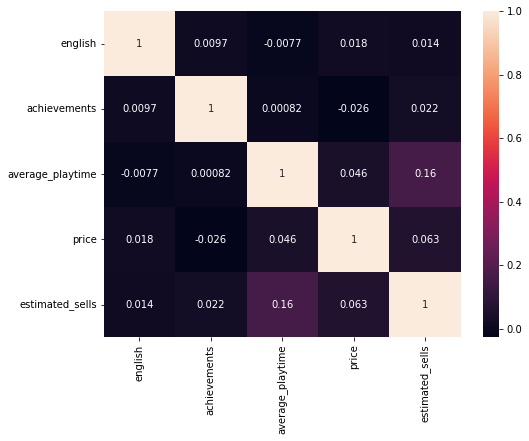

In [5]:
corr_df = df_train.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.savefig("corr.png")
plt.show()

Observamos que para la variable price la mayoría de los datos estan bajo los 20 dolares, y se ve que hay juegos de precio 0, lo cual nos dice que son del tipo "free to play"

Para la variable achievements, al eliminar los outliers, vemos que la mayoría está entre 0-9.

Y por último para la variable average_playtime, observamos que hay una gran cantidad de ceros siendo estos al rededor del 40% de los datos. Por lo que se tiene un promedio al rededor de los 400 minutos.

Se observa que tanto la columna publisher como la developer, son muy parecidas, por lo que se decide quedar solamente con publisher. 

Por otro lado, para las plataformas, observamos que la mayoría de los juegos están hechos solo para windows.

Podemos observar en la matriz de correlación que las columnas que tienen una mayor relacion es average_playtime con estimated_sells, además, no hay datos nulos en este dataframe.

---

## 3. Preparación de Datos

Se separa la data de los labels.

In [6]:
## Código
x = df_train.iloc[:,:14]
y = df_train.iloc[:,14:16]

En consideración de las observaciones realizadas en la sección anterior se dropean las columnas que no se consideran relevante para realizar la predicción o que repiten información de otras columnas.

In [7]:
#drops
dropables = ["developer", "name", "tags", "required_age"]
x.drop

<bound method DataFrame.drop of                       name release_date  english  \
0            An Aspie Life   2018-03-29     True   
1        GhostControl Inc.   2014-06-06     True   
2                  Deponia   2012-08-06     True   
3            Atlas Reactor   2016-10-04     True   
4                  CHUCHEL   2018-03-07     True   
...                    ...          ...      ...   
7876  KOEWOTAYORINI / 声之寄托   2018-03-26    False   
7877               Montaro   2016-07-25     True   
7878            Moe Jigsaw   2018-03-23     True   
7879      Drunkn Bar Fight   2016-11-28     True   
7880                Intake   2013-11-06     True   

                         developer                       publisher  \
0     Bradley Hennessey;Joe Watson               EnderLost Studios   
1                        bumblebee  Application Systems Heidelberg   
2           Daedalic Entertainment          Daedalic Entertainment   
3                     Trion Worlds                    Trion Wor

Se construyó una función llamada SuperDummier para realizar un One Hot Encode sobre las variables categóricas del dataset. Cabe destacar que para los publishers solo se incluyó a las compañías que hayan desarrollado al menos 10 juegos.

In [8]:
## Código
def SuperDummier(df_in, col):
    df = df_in.copy()
    df[col] = df[col].apply(lambda x: str(x).split(";"))
    s = pd.Series(df[col])
    l = pd.get_dummies(s.apply(pd.Series).stack(), prefix=col).max(level=0)
    if col=="publisher":
        l.drop(l.columns[l.apply(lambda c: c.sum() < 10)], axis=1, inplace=True)
    df = pd.concat((df.drop(col,1),l),axis=1)
    return df

X = SuperDummier(x,"publisher")
X = SuperDummier(X,"platforms")
X = SuperDummier(X,"categories")
X = SuperDummier(X,"genres")

Se establece la función para usar el bag of words.

In [9]:
stop_words = stopwords.words('english')

# Definimos un tokenizador con Stemming
class StemmerTokenizer:
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in stop_words]
        return [self.ps.stem(t) for t in doc_tok]

Luego, preparamos un `ColumnTransformer` que prepara los datos:

In [10]:
preprocessing = ColumnTransformer(
    transformers=[
        ('BagOfWords', CountVectorizer(tokenizer= StemmerTokenizer(), ngram_range=(1,2)),'short_description'),
        ('StandardScaler', StandardScaler(),['price']), 
        ('MinMaxScaler',  MinMaxScaler(),['achievements','average_playtime'])
    ],
    remainder="drop"
)

---

## 4. Baseline

Adjuntamos las transformaciones anteriores en un solo `Pipeline` y agregamos al final un clasificador Dummy para ambos problemas.


In [11]:
baseline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=90)),
        ("dummy", DummyClassifier())
    ]
)

X_train, X_test, y_train, y_test = train_test_split(x, y.iloc[:,1:2], test_size=0.20)

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print(f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

0.10542112713934004
                 precision    recall  f1-score   support

          Mixed       0.00      0.00      0.00       343
Mostly Positive       0.00      0.00      0.00       344
       Negative       0.00      0.00      0.00       271
       Positive       0.26      1.00      0.41       406
  Very Positive       0.00      0.00      0.00       213

       accuracy                           0.26      1577
      macro avg       0.05      0.20      0.08      1577
   weighted avg       0.07      0.26      0.11      1577



In [12]:
baseline_reg = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=90)),
        ("DummyReg", DummyRegressor())
    ]
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x, y.iloc[:,0:1], test_size=0.20)

baseline_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = baseline_reg.predict(X_test_reg)
print(r2_score(y_test_reg, y_pred_reg))

-0.0008612260987994613


---

## 5. Optimización del Modelo

Se realizó una función para evaluar distintar grillas con las métricas del proyecto.

In [13]:
def evaluate_Grid(param, train_X, train_y, test_X, test_y, metric):
    clf = param['clf']
    param.pop('clf')

    selection = param['selection']
    param.pop('selection')

    bog = param['bog']
    param.pop('bog')

    preprocessing2 = ColumnTransformer(
    transformers=[
        ('bog', bog ,'short_description'),
        ('StandardScaler', StandardScaler(),['price']), 
        ('MinMaxScaler',  MinMaxScaler(),['achievements','average_playtime'])
    ],  
    remainder="drop"
    )

    pipe = Pipeline([("Preprocessing", preprocessing2),
    ("selection", selection),
    ("clf", clf)])

    grid = HalvingGridSearchCV(pipe, param_grid=param, random_state=0, min_resources=2, scoring=metric)
    grid.fit(train_X, train_y)
    y_pred = grid.best_estimator_.predict(test_X)
    print(f"Clasificador {clf}")
    print(f"Mejores estimadores {grid.best_estimator_}")
    if metric == "f1_weighted":
        score = f1_score(test_y, y_pred,average="weighted")
    if metric == "r2":
        score = r2_score(test_y, y_pred)
    print(score)
    return (grid.best_estimator_, score)

Se procedió a evaluar los modelos elegidos para el proyecto con sus respectivas combinaciones de parámetros.

In [14]:
params_RFC = {'clf': RandomForestClassifier(),
    'clf__n_estimators': [100,300, 1000],
    'selection': SelectPercentile(f_classif),
    'selection__percentile': [20, 40, 60, 80],
    'bog': CountVectorizer(tokenizer= StemmerTokenizer()),
    'Preprocessing__bog__ngram_range': [(1,1),(1,2), (1,3)],
    }
       
params_KNN ={'clf': KNeighborsClassifier(),
    'clf__weights': ['uniform', 'distance'],
    'selection': SelectPercentile(f_classif),
    'selection__percentile': [20, 40, 60, 80],
    'bog': CountVectorizer(tokenizer= StemmerTokenizer()),
    'Preprocessing__bog__ngram_range': [(1,1), (1,2), (1,3)],
    }

In [30]:
grid_RFC = evaluate_Grid(param=params_RFC, train_X=X_train, train_y=y_train, test_X=X_test, test_y=y_test, metric="f1_weighted")

Clasificador RandomForestClassifier()
Mejores estimadores Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bog',
                                                  CountVectorizer(tokenizer=<__main__.StemmerTokenizer object at 0x000001A4ADF530A0>),
                                                  'short_description'),
                                                 ('StandardScaler',
                                                  StandardScaler(), ['price']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['achievements',
                                                   'average_playtime'])])),
                ('selection', SelectPercentile(percentile=20)),
                ('clf', RandomForestClassifier(n_estimators=1000))])
0.27777807548053607


In [15]:
grid_KNN = evaluate_Grid(param=params_KNN, train_X=X_train, train_y=y_train, test_X=X_test, test_y=y_test, metric="f1_weighted")

Clasificador KNeighborsClassifier()
Mejores estimadores Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bog',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x000001D90DFADC40>),
                                                  'short_description'),
                                                 ('StandardScaler',
                                                  StandardScaler(), ['price']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['achievements',
                                                   'average_playtime'])])),
                ('selection', SelectPercentile(percentile=

In [37]:
params_ElasticNet ={'clf': ElasticNet(),
    'clf__alpha': [0.1,0.5,1],
    'clf__l1_ratio': [0.5,1],
    'selection': SelectPercentile(f_regression),
    'selection__percentile': [40, 80],
    'bog': CountVectorizer(tokenizer= StemmerTokenizer()),
    'Preprocessing__bog__ngram_range': [(1,1),(1,2), (1,3)],
    }

params_RFR = {'clf': RandomForestRegressor(),
    'clf__n_estimators': [100],
    'selection': SelectPercentile(f_regression),
    'selection__percentile': [40, 80],
    'bog': CountVectorizer(tokenizer= StemmerTokenizer()),
    'Preprocessing__bog__ngram_range': [(1,1), (1,2), (1,3)],       
    }

In [ ]:
grid_elastic = evaluate_Grid(param=params_ElasticNet, train_X=X_train_reg, train_y=y_train_reg, test_X=X_test_reg, test_y=y_test_reg, metric="r2")

Clasificador ElasticNet()
Mejores estimadores Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bog',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x000001D90D10D9D0>),
                                                  'short_description'),
                                                 ('StandardScaler',
                                                  StandardScaler(), ['price']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['achievements',
                                                   'average_playtime'])])),
                ('selection',
                 SelectPercentile(perc

In [ ]:
grid_RFR = evaluate_Grid(param=params_RFR, train_X=X_train_reg, train_y=y_train_reg, test_X=X_test_reg, test_y=y_test_reg, metric="r2")

Clasificador RandomForestRegressor()
Mejores estimadores Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bog',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x000001D90D0A21C0>),
                                                  'short_description'),
                                                 ('StandardScaler',
                                                  StandardScaler(), ['price']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['achievements',
                                                   'average_playtime'])])),
                ('selection',
                 SelectPerc

Pudimos ver que los modelos propuestos superan el baseline Dummy propuesto en la sección anterior. Finalmente se eligen los modelos con mejor score en su respectica métrica.

---

## 6. Conclusiones

En consideración de los resultados se puede concluir que se resolvieron los dos problemas planteados por el proyecto, ya que se obtuvieron mejores resultados en la fase de optimización que en el baseline planteado con modelos Dummy, por lo que se puede afirmar que la base de entrenamiento generada permite el aprendizaje, además se obtuvieron resultados finales cercanos al baseline propuesto por el cuerpo docente, aunque estos no fueron superados.

Respecto a los objetivos planteados por el equipo se puede afirmar que se cumplieron casi en su totalidad, ya que también se había planteado una fase de mejora con selección de variables mediante librerías como shap y feature_selection de sklearn, pero por problemas de compatibilidad con los pipelines no se pudo concretar esta fase y se terminó descartando debido al tiempo disponible.

En consideración de lo anterior se puede decir que estamos conformes con el proyecto ya que obtuvimos unas base sólida para el proyecto que permitiría seguir realizando más experimentos interesantes y resultados preeliminares relativamente buenos, aún así nos hubiera gustado poder dedicar más tiempo para mejorar los resultados.

También cabe destacar la importancia de considerar los recursos computacionales en la estimación de tiempo de trabajo, ya que consideramos que este punto fue el principal menguante en el desarrollo de nuestro proyecto.

Finalmente desde un punto de vista pedagógico consideramos que el proyecto fue éxito, ya que sirvió para aplicar y afianzar los conocimientos adquiridos a lo largo del curso en un problema complejo.